<a href="https://colab.research.google.com/github/jellyho/AI_Learning_jellyho/blob/main/8_Parameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


데이터 전처리

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

파이프라인으로 변환기와 추정기를 연결할 수 있다. 그래야 학습하면서 변환기에 저장된 파라미터들을 재사용하여 테스트 데이터도 같이 변환할 수 있는데 이를 파이프라인으로 쉽게 연결 할 수 있다.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), PCA(n_components=2,), LogisticRegression(solver='liblinear', random_state=1))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(f'테스트 정확도: {pipe.score(X_test, y_test)}')

테스트 정확도: 0.956140350877193


모델 성능 평가하기


초기 데이터셋을 훈련세트와 검증세트, 그리고 테스트 세트로 나눈다. 그리고 훈련세트로 훈련하고 검증세트로 검증하면서 반복적으로 모델을 훈련하며 파라미터를 변경하고 마지막으로 테스트 세트로 테스트 하면서 모델의 일반화 성능을 추정한다. 그러나 이는 어떻게 데이터 세트를 나누는지에 따라서 훈련 모델의 성능 추정이 크게 달라질 수 있다는 단점이 있다. 그렇기 때문에 k-겹 교차 검증을 사용한다.

k-겹 교차 검증은 훈련 데이터셋을 k개의 폴드로 나누고 k-1개의 폴드로 훈련하고 나머지 한개의 폴드로 테스트를 진행해 성능을 평가하고 이것을 k번 반복하여 k개의 성능 추정을 얻는다. 이것을 모델의 평균 성능을 계산한다. 그리고 전체 훈련세트로 다시 한번 훈련을 하고 독립된 테스트셋으로 최종 성능 추정을 낸다.

계층적 k-겹 교차 검증은 더 나은 편향과 분산 추정을 만든다. 특히 클래스 비율이 동등하지 않은 경우가 많은데 이때 더 유용하다.
계층적 k-겹 교차 검증은 각 폴드에서 클래스 비율이 전체 훈련 세트의 클래스 비율과 비슷하도록 유지한다.

In [4]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
  pipe.fit(X_train[train], y_train[train])
  score = pipe.score(X_train[test], y_train[test])
  scores.append(score)
  print(f'{np.bincount(y_train[test])} {score}')

[29 17] 0.9347826086956522
[29 17] 0.9347826086956522
[29 17] 0.9565217391304348
[29 17] 0.9565217391304348
[29 17] 0.9347826086956522
[28 17] 0.9555555555555556
[28 17] 0.9777777777777777
[28 17] 0.9333333333333333
[28 17] 0.9555555555555556
[28 17] 0.9555555555555556


In [5]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10, n_jobs=1)
scores

array([0.93478261, 0.93478261, 0.95652174, 0.95652174, 0.93478261,
       0.95555556, 0.97777778, 0.93333333, 0.95555556, 0.95555556])

학습곡선과 검증곡선을 이용해서 알고리즘 디버깅

과소적합 혹은 과대적합을 찾아낼 수 있다.

만약 높은 편향이 보여진다면? 이것은 과소 적합의 증거이다. 즉, 모델을 더 복잡하게 만들어야 된다. 파라미터를 더 추가하는 것이 좋다.

만약 그러면 높은 분산이 보여진다면, 과대 적합이 되었을 가능성이 높다. 즉, 모델을 더 간단하게 만들어야 한다. 특성 선택이나 특성 추출, 혹은 규제를 통해서 과대 적합의 가능성을 줄인다.

만약 이걸로도 해결이 잘 안된다면? 학습곡선과 검증 곡선을 사용하여 이런 문제를 다루어보자.

학습곡선 만들기

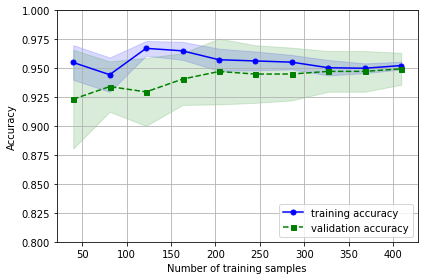

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2,), LogisticRegression(solver='liblinear', random_state=1, penalty='l2'))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

학습 곡선을 보면 알 수 있듯이, 샘플의 수가 300개 정도 되었을 때 학습 정확도와 검증 정확도가 비슷해졌다. 샘플의 수가 적었을 때는 이 차이가 커지는데 이는 과대 적합 상태였음을 알 수 있다.

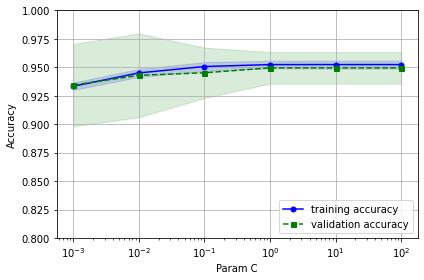

In [17]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
pipe_lr2 = make_pipeline(StandardScaler(), PCA(n_components=2,), LogisticRegression(solver='liblinear', random_state=1, penalty='l2'))
train_scores, test_scores = validation_curve(estimator=pipe_lr2, X=X_train, y=y_train, param_name='logisticregression__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Param C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

그리드 서치를 이용해서 머신 러닝 모델 세부 튜닝

그리드 서치는 말 그대로 하이퍼파라미터 값 전체를 모두 조사해서 가장 좋은 결과값을 뽑는 방법이다.

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001 * 10 ** i for i in range(8)]

param_grid = [{'svc__C': param_range, 'svc__kernel':['linear']},{'svc__C':param_range, 'svc__gamma':param_range, 'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [29]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9736842105263158


여러가지 성능 평가 지표들

1. 오차 행렬

In [32]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conmat)

[[71  1]
 [ 2 40]]


정확도와 재현율
ACC는 어떠한 클래스로 분류된 것 중에 실제 그 클래스의 비율
REC는 실제 그 클래스 중에서 그 클래스로 분류된 경우의 비율
F1은 이 둘을 조합한 점수! F1-Score


In [33]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print(precision_score(y_true=y_test, y_pred=y_pred))
print(recall_score(y_true=y_test, y_pred=y_pred))
print(f1_score(y_true=y_test, y_pred=y_pred))

0.975609756097561
0.9523809523809523
0.963855421686747


정확도 말고 다른 지표를 사용하여 학습하기

In [34]:
from sklearn.metrics import make_scorer
scorer = make_scorer(f1_score, pos_label=0)
gsgs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)